In [1]:
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Resize, Compose

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
mps_avail = torch.backends.mps.is_available()
device = torch.device("mps" if mps_avail else "cpu")
if torch.cuda.is_available(): device = torch.device("cuda")
device

device(type='cuda')

In [3]:
class Inception(nn.Module):
    # output channels 
    def __init__(self, in_channels: int, bc1: int, bc2: [], bc3: [], bc4: int):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=bc1, kernel_size=1),
            nn.ReLU()
        )
        self.b2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=bc2[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=bc2[0], out_channels=bc2[1], kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.b3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=bc3[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=bc3[0], out_channels=bc3[1], kernel_size=5, padding=2),
            nn.ReLU()
        )
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=in_channels, out_channels=bc4, kernel_size=1)
        )

    def forward(self, x):
        return torch.concat(
            (self.b1(x), self.b2(x), self.b3(x), self.b4(x)),
            dim=1
        )
     
sample = torch.rand((1,1,28,28))
model = Inception(1, 6, [3, 6], [4, 6], 6)
print(sample.shape, "--->", model(sample).shape)

torch.Size([1, 1, 28, 28]) ---> torch.Size([1, 24, 28, 28])


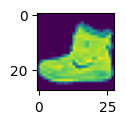

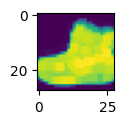

In [4]:
x = FashionMNIST(root="../datasets/", train=True, transform=ToTensor()).data[0].unsqueeze(dim=0).unsqueeze(dim=0).type(torch.float)
plt.figure(figsize=(1,1))
plt.imshow(x.squeeze())
plt.figure(figsize=(1,1))
plt.imshow(F.max_pool2d(input=x, kernel_size=3, stride=1, padding=1).squeeze())

In [9]:
class MiniGoogLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1, stride=1),
            nn.ReLU(),
            
            Inception(3, 16, [8, 16], [8, 16], 16),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14x14

            Inception(16*4, 8, [12, 8], [12, 8], 8),
            nn.MaxPool2d(kernel_size=2, stride=2), # 7x7

            Inception(8*4, 4, [6, 4], [6, 4], 4),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1), # 4,4
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=4*4, out_features=10)
        )
    def forward(self, x):
        return self.layer_stack(x)

In [10]:
BS = 32

train_dataloader = DataLoader(
    FashionMNIST(root="../datasets/", train=True, transform=ToTensor()),
    batch_size=BS, shuffle=True
)
test_dataloader = DataLoader(
    FashionMNIST(root="../datasets/", train=False, transform=ToTensor()),
    batch_size=BS, shuffle=False
)

In [17]:
model = MiniGoogLeNet()
model = model.to(device)

losses = []
accs = []

In [48]:
N_EPOCHS = 1
LR = 0.001

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model.parameters(), lr=LR,)

for epoch in tqdm(range(N_EPOCHS)):

    for batch, (x, y) in enumerate(train_dataloader):

        x = x.to(device)
        y = y.to(device)

        optim.zero_grad()

        out = model(x)
        
        acc = (out.argmax(dim=1).detach().cpu()==y.detach().cpu()).sum().item()/BS
        accs.append(acc)
        
        loss = loss_fn(out, y)
        losses.append(loss.item())

        loss.backward()
        optim.step()

        if batch % 350 == 0: print("Loss:", loss.item()/float(BS), "Acc:", acc)

  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.012513227760791779 Acc: 0.8125
Loss: 0.00453281169757247 Acc: 0.96875
Loss: 0.0031331167556345463 Acc: 1.0
Loss: 0.008945821784436703 Acc: 0.90625
Loss: 0.009249480441212654 Acc: 0.90625
Loss: 0.005233455449342728 Acc: 0.96875


100%|██████████| 1/1 [00:11<00:00, 11.76s/it]


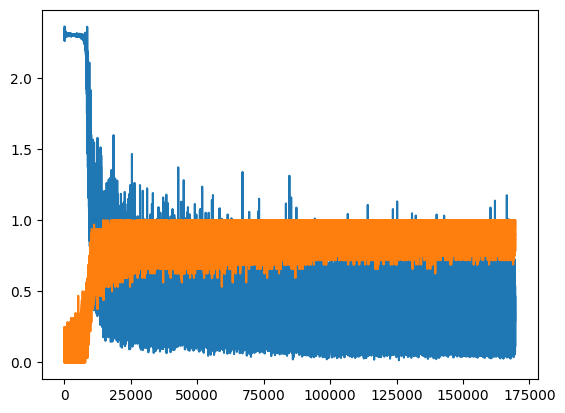

In [49]:
plt.plot(losses)
plt.plot(accs)

In [50]:
score = 0
for (x, y) in test_dataloader:
    out = model(x.to(device))
    score += (out.argmax(dim=1).detach().cpu()==y).sum().item()
print(score)

8855
